# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from google.colab import files
import pickle
import os

!pip install scipy
import scipy.stats as stats

!pip install papermill
!pip install nbconvert
!pip install nbformat
!pip install IPython

import papermill as pm
import nbformat
from nbconvert import HTMLExporter
from IPython.display import HTML, display

import json
from google.colab import drive

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
BG_BLACK = "\033[40m"
BG_RED = "\033[41m"
BG_GREEN = "\033[42m"
BG_YELLOW = "\033[43m"
BG_BLUE = "\033[44m"
BG_MAGENTA = "\033[45m"
BG_CYAN = "\033[46m"
BG_WHITE = "\033[47m"
BG_DARK_GRAY = "\033[100m"
BG_BRIGHT_RED = "\033[101m"
BG_BRIGHT_GREEN = "\033[102m"
BG_BRIGHT_YELLOW = "\033[103m"
BG_BRIGHT_BLUE = "\033[104m"
BG_BRIGHT_MAGENTA = "\033[105m"
BG_BRIGHT_CYAN = "\033[106m"
BG_WHITE = "\033[107m"
RESET = "\033[0m" # Reset all formatting

# Bootstrap

In [ ]:
import os
from dotenv import load_dotenv

# Find and load the .env file from the current or parent directories
load_dotenv()

# Access the environment variable using os.getenv()
PROJECT_PATH = os.getenv('PROJECT_PATH')
CONFIG_FILE = f"{PROJECT_PATH}src/config.json"

In [ ]:
PROJECT_PATH

'/content/drive/MyDrive/Projects/GitHub/Spotify/'

In [ ]:
os.path.exists("/content/drive/MyDrive/Projects/GitHub/Spotify/src/config.json")

True

In [ ]:
drive.mount('/content/drive')

with open(CONFIG_FILE, 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
np.random.seed(31071967)

# Run project notebook N-1

Executing:   0%|          | 0/32 [00:00<?, ?cell/s]


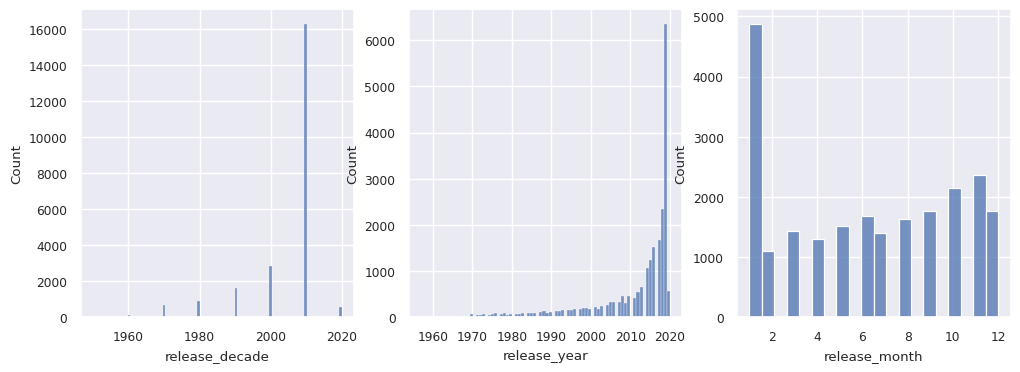
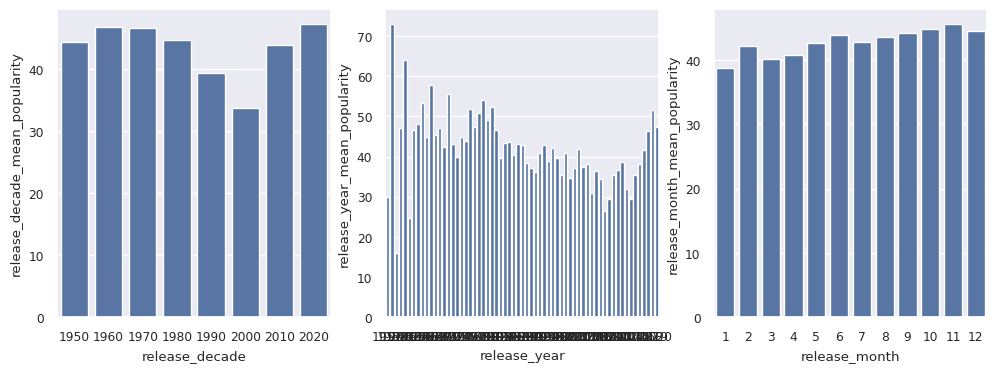
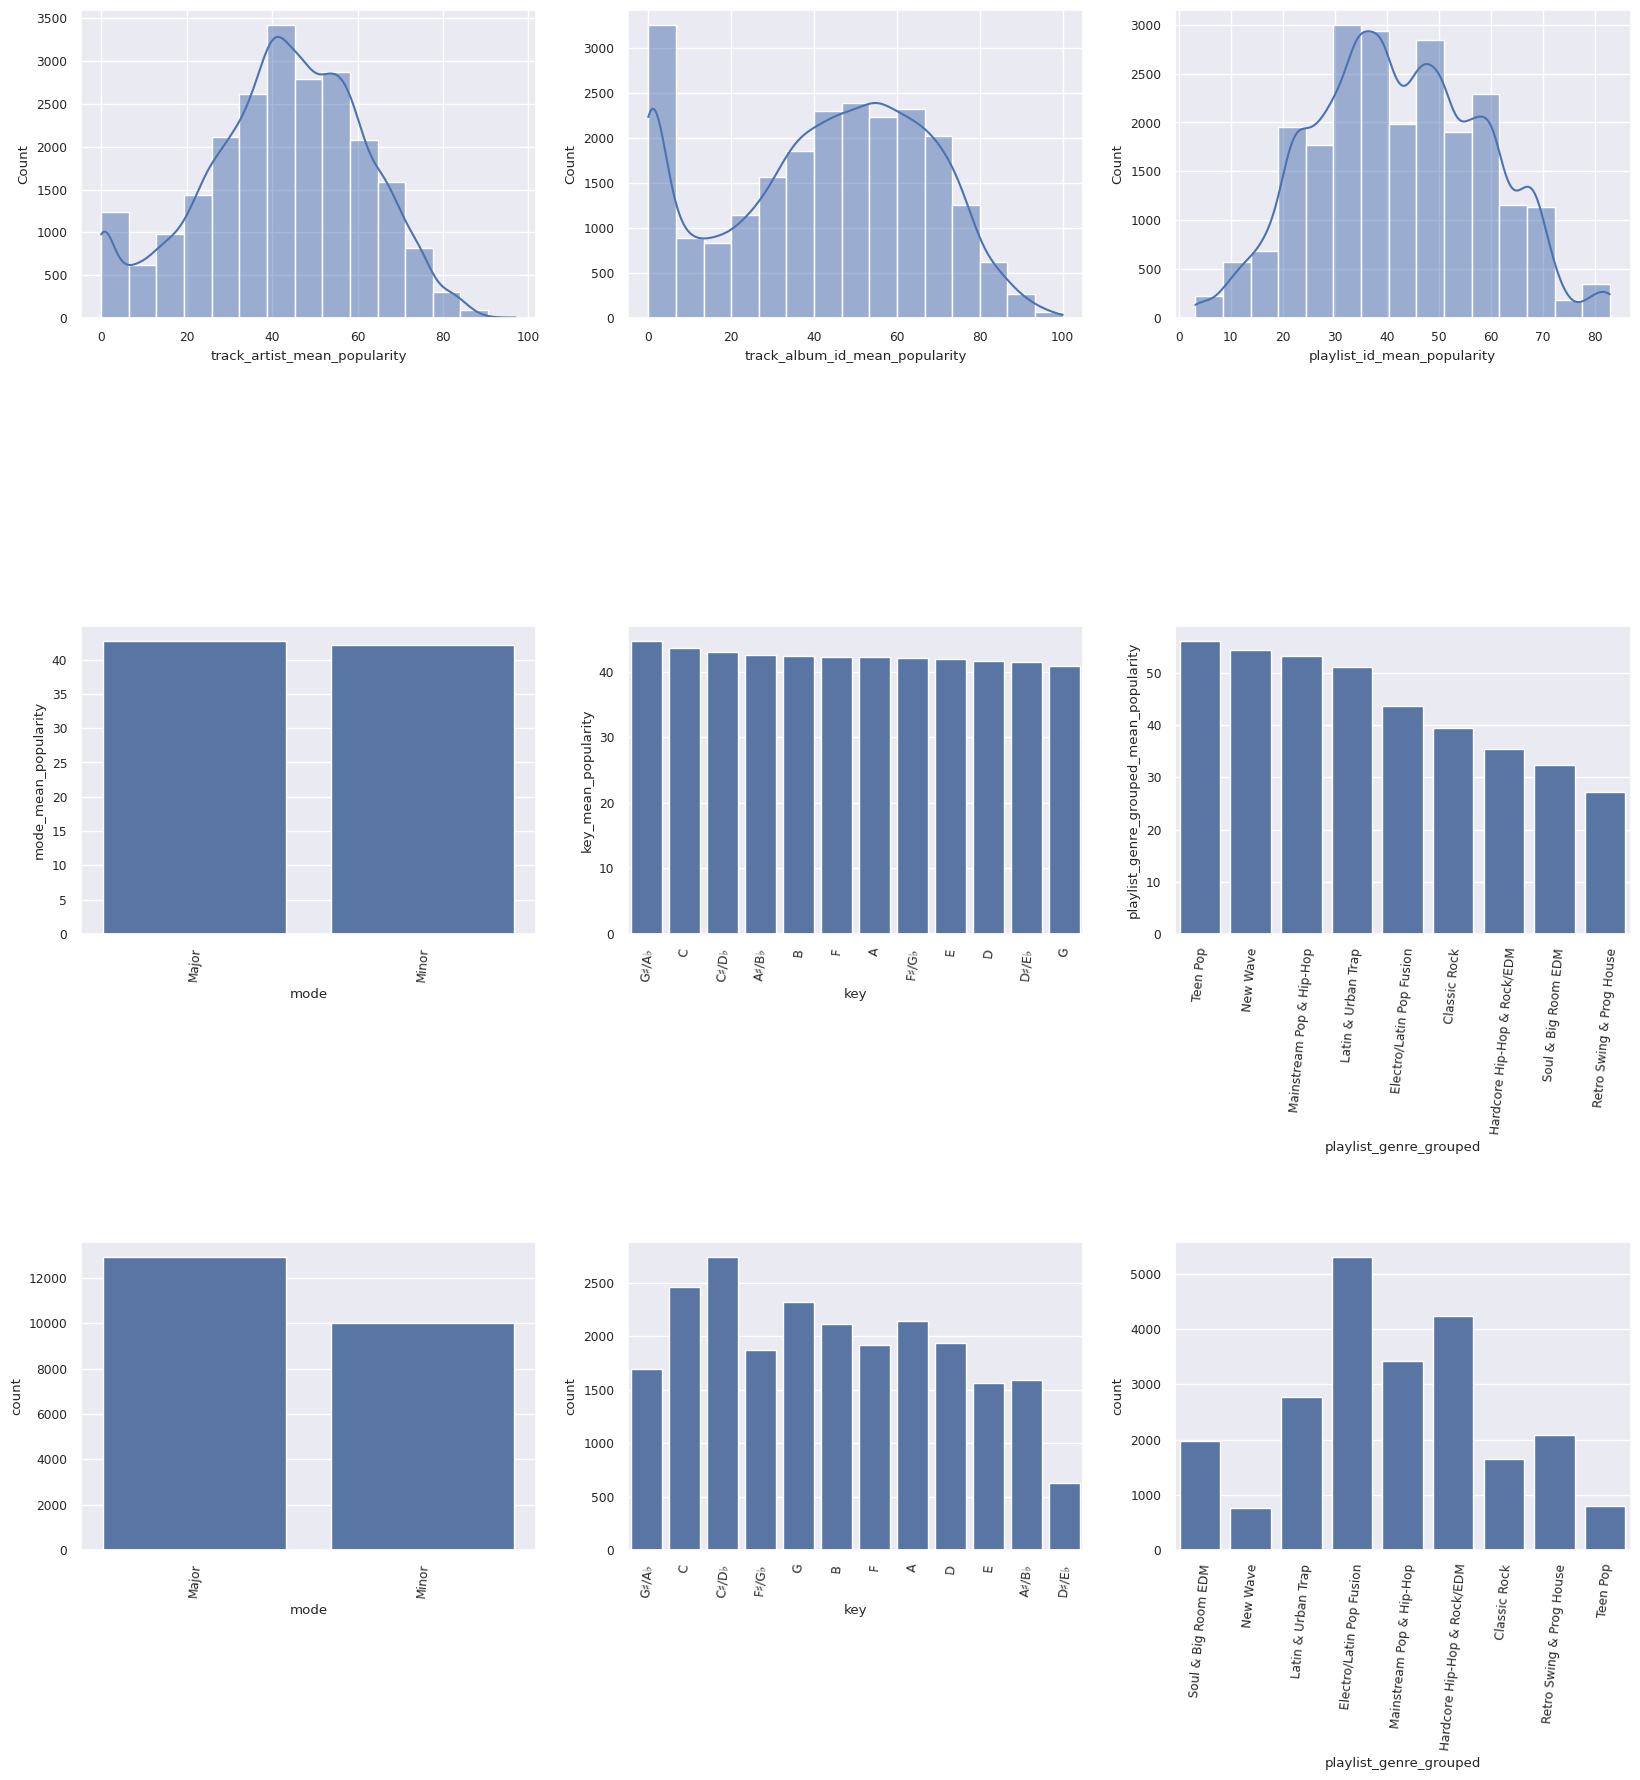
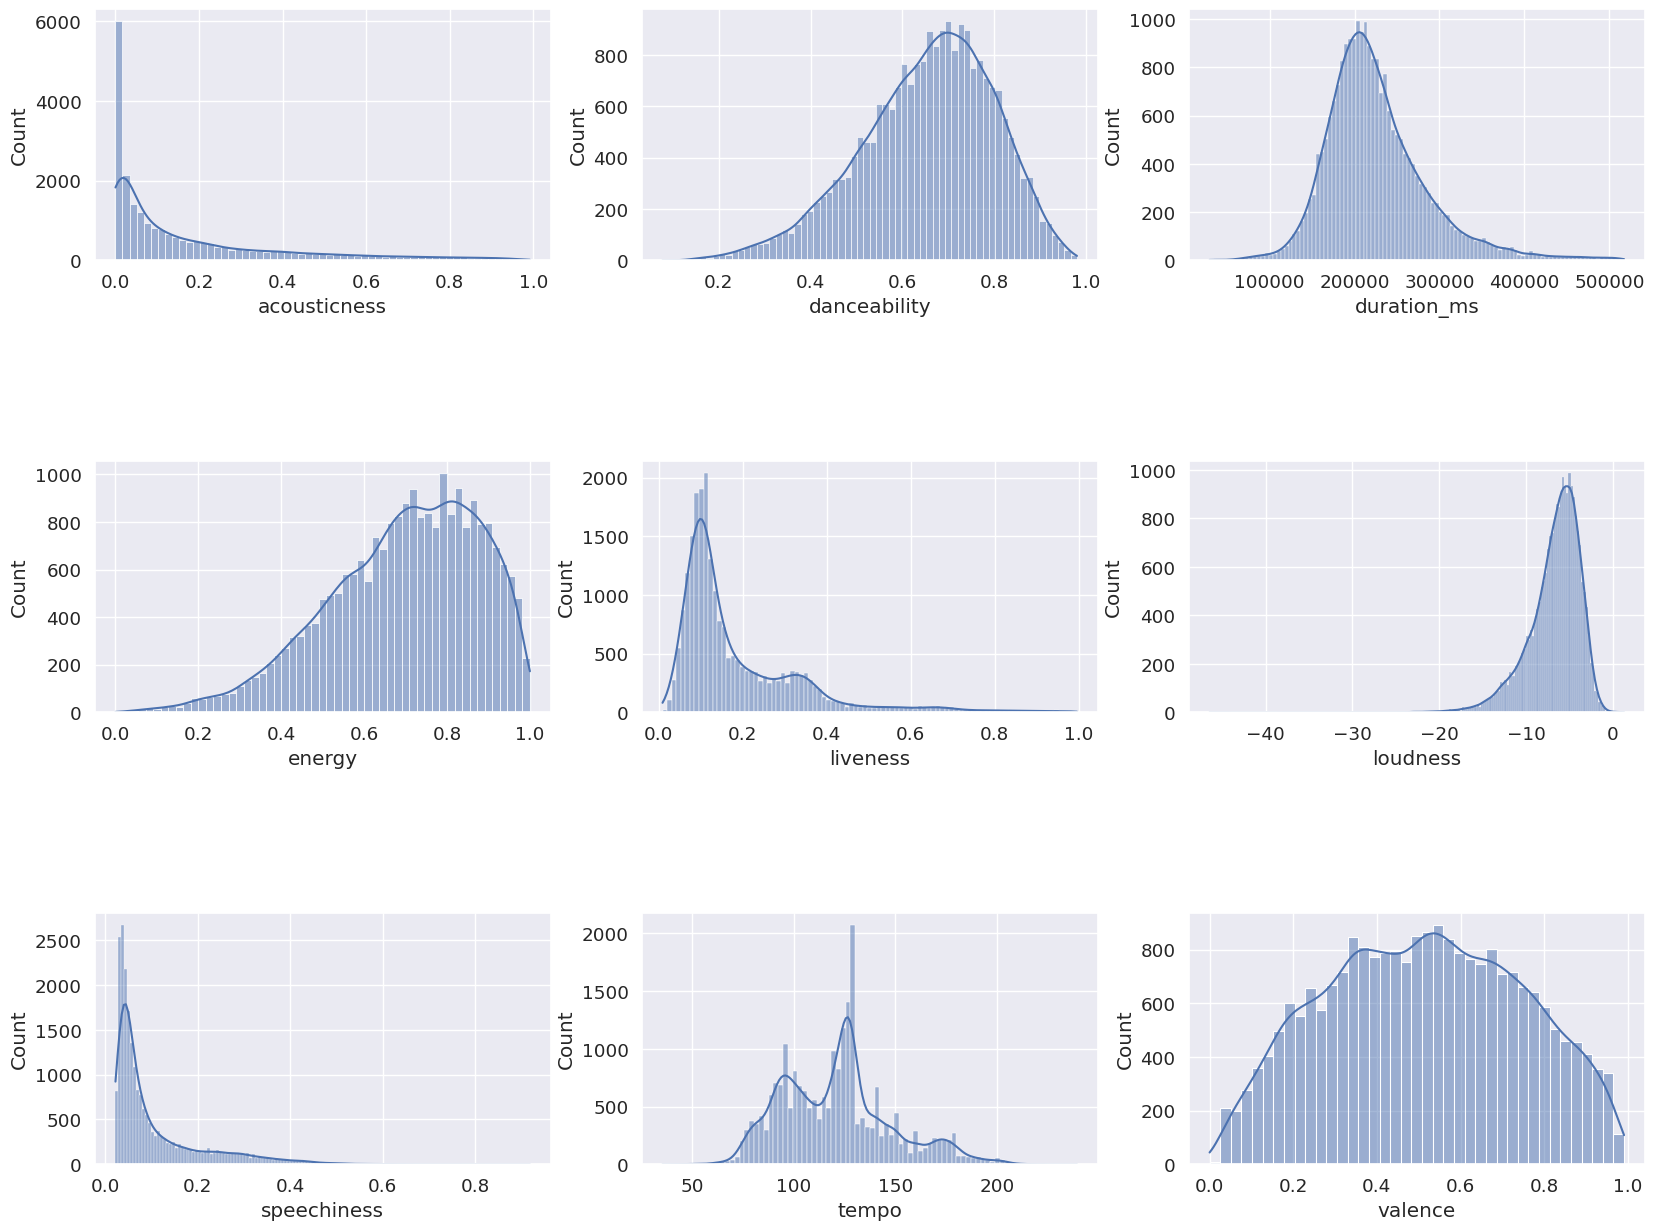

In [ ]:
if project_config['chain_notebooks'] == '1':

  input_file = f"{PROJECT_PATH}{project_config['notebooks_directory']}{project_config['notebook1']}"
  output_file = f"{PROJECT_PATH}{project_config['output_directory']}{project_config['output1']}"

  # --- Execute the proviuse notebook with parameters ---
  pm.execute_notebook(
      input_path = input_file,
      output_path = output_file,
      log_output=False,  # don't print logs while running
      progress_bar=True
  )

  # --- Convert the executed notebook to HTML ---
  nb = nbformat.read(output_file, as_version=4)
  html_exporter = HTMLExporter()
  html_exporter.template_name = "lab"  # modern look; alternatives: 'classic', 'basic'
  body, _ = html_exporter.from_notebook_node(nb)

  # --- Display the HTML result inline ---
  display(HTML(body))

# Load pickle

In [ ]:
pickle_file      = PROJECT_PATH + project_config['pickles_directory'] + project_config['pickle1']
test_pickle_file = PROJECT_PATH + project_config['pickles_directory'] + project_config['pickle1_test']

In [ ]:
# Read pickle into DataFrame
df = pd.read_pickle(pickle_file)
display(df.head(1)), display(df.tail(1))

,track_id,track_artist,track_popularity,track_album_id,playlist_id,danceability,energy,key,loudness,mode,...,release_decade_mean_popularity,release_month_mean_popularity,release_year_mean_popularity,playlist_genre_grouped,track_artist_mean_popularity,track_album_id_mean_popularity,playlist_id_mean_popularity,mode_mean_popularity,key_mean_popularity,playlist_genre_grouped_mean_popularity
26210,6GnhWMhgJb7uyiiPEiEkDA,Mac Miller,77,2Tyx5dLhHYkx6zeAdVaTzN,2ujrP2rPxu8ao7wNeG1ZOY,0.843,0.435,G♯/A♭,-8.442,Major,...,43.817673,44.145998,35.485437,Soul & Big Room EDM,67.933333,77.0,39.895522,42.769249,44.744681,32.370314


,track_id,track_artist,track_popularity,track_album_id,playlist_id,danceability,energy,key,loudness,mode,...,release_decade_mean_popularity,release_month_mean_popularity,release_year_mean_popularity,playlist_genre_grouped,track_artist_mean_popularity,track_album_id_mean_popularity,playlist_id_mean_popularity,mode_mean_popularity,key_mean_popularity,playlist_genre_grouped_mean_popularity
15795,5ZkHhBQnPdVTYPxyCvnRGo,Chris Blackburger,28,3IFirXg4IpKos5E9FCJmfO,28817h8FTrRI4V40DqHVaB,0.408,0.972,D,-3.486,Major,...,43.817673,44.843083,51.517545,Hardcore Hip-Hop & Rock/EDM,28.0,28.0,28.060606,42.769249,41.710227,35.444943


(None, None)

In [ ]:
# types of cols
small_cat_cols     = ['mode_mean_popularity','key_mean_popularity', 'playlist_genre_grouped_mean_popularity','release_decade_mean_popularity','release_month_mean_popularity']
small_cat_symboles = ['mode','key','playlist_genre_grouped','release_decade','release_month', 'release_year']
large_cat_cols     = ['track_artist_mean_popularity','track_album_id_mean_popularity','playlist_id_mean_popularity']
cont_cols          = ['acousticness', 'danceability','duration_ms','energy', 'liveness', 'loudness', 'speechiness', 'tempo','valence']
y_col              = 'track_popularity'
x_cols             = large_cat_cols + small_cat_cols + cont_cols
MERGE_ON_COL       = 'track_id'

# Skewness, Boxplots

In [ ]:
# Reset counts before applying the function
normal_distributions = 0
other_distributions = 0

def highlight_distribution_type(cell_value):

    highlight = 'background-color: mediumspringgreen;'
    default = ''
    negative = 'background-color: hotpink;'

    global normal_distributions, other_distributions

    if cell_value > 1:
        other_distributions += 1
        return highlight
    elif cell_value < -1:
        other_distributions += 1
        return negative
    else:
        normal_distributions += 1
        return default

display( pd.DataFrame(df[[y_col]+x_cols].skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight_distribution_type) )

print(f'Normal distributions: {normal_distributions}')
print(f'Other distributions: {other_distributions}')

,skewness
liveness,2.081559
speechiness,1.942636
acousticness,1.588663
duration_ms,1.166346
key_mean_popularity,0.677862
tempo,0.533938
playlist_id_mean_popularity,0.093484
valence,-0.002819
playlist_genre_grouped_mean_popularity,-0.109053
track_popularity,-0.230117


Normal distributions: 12
Other distributions: 6


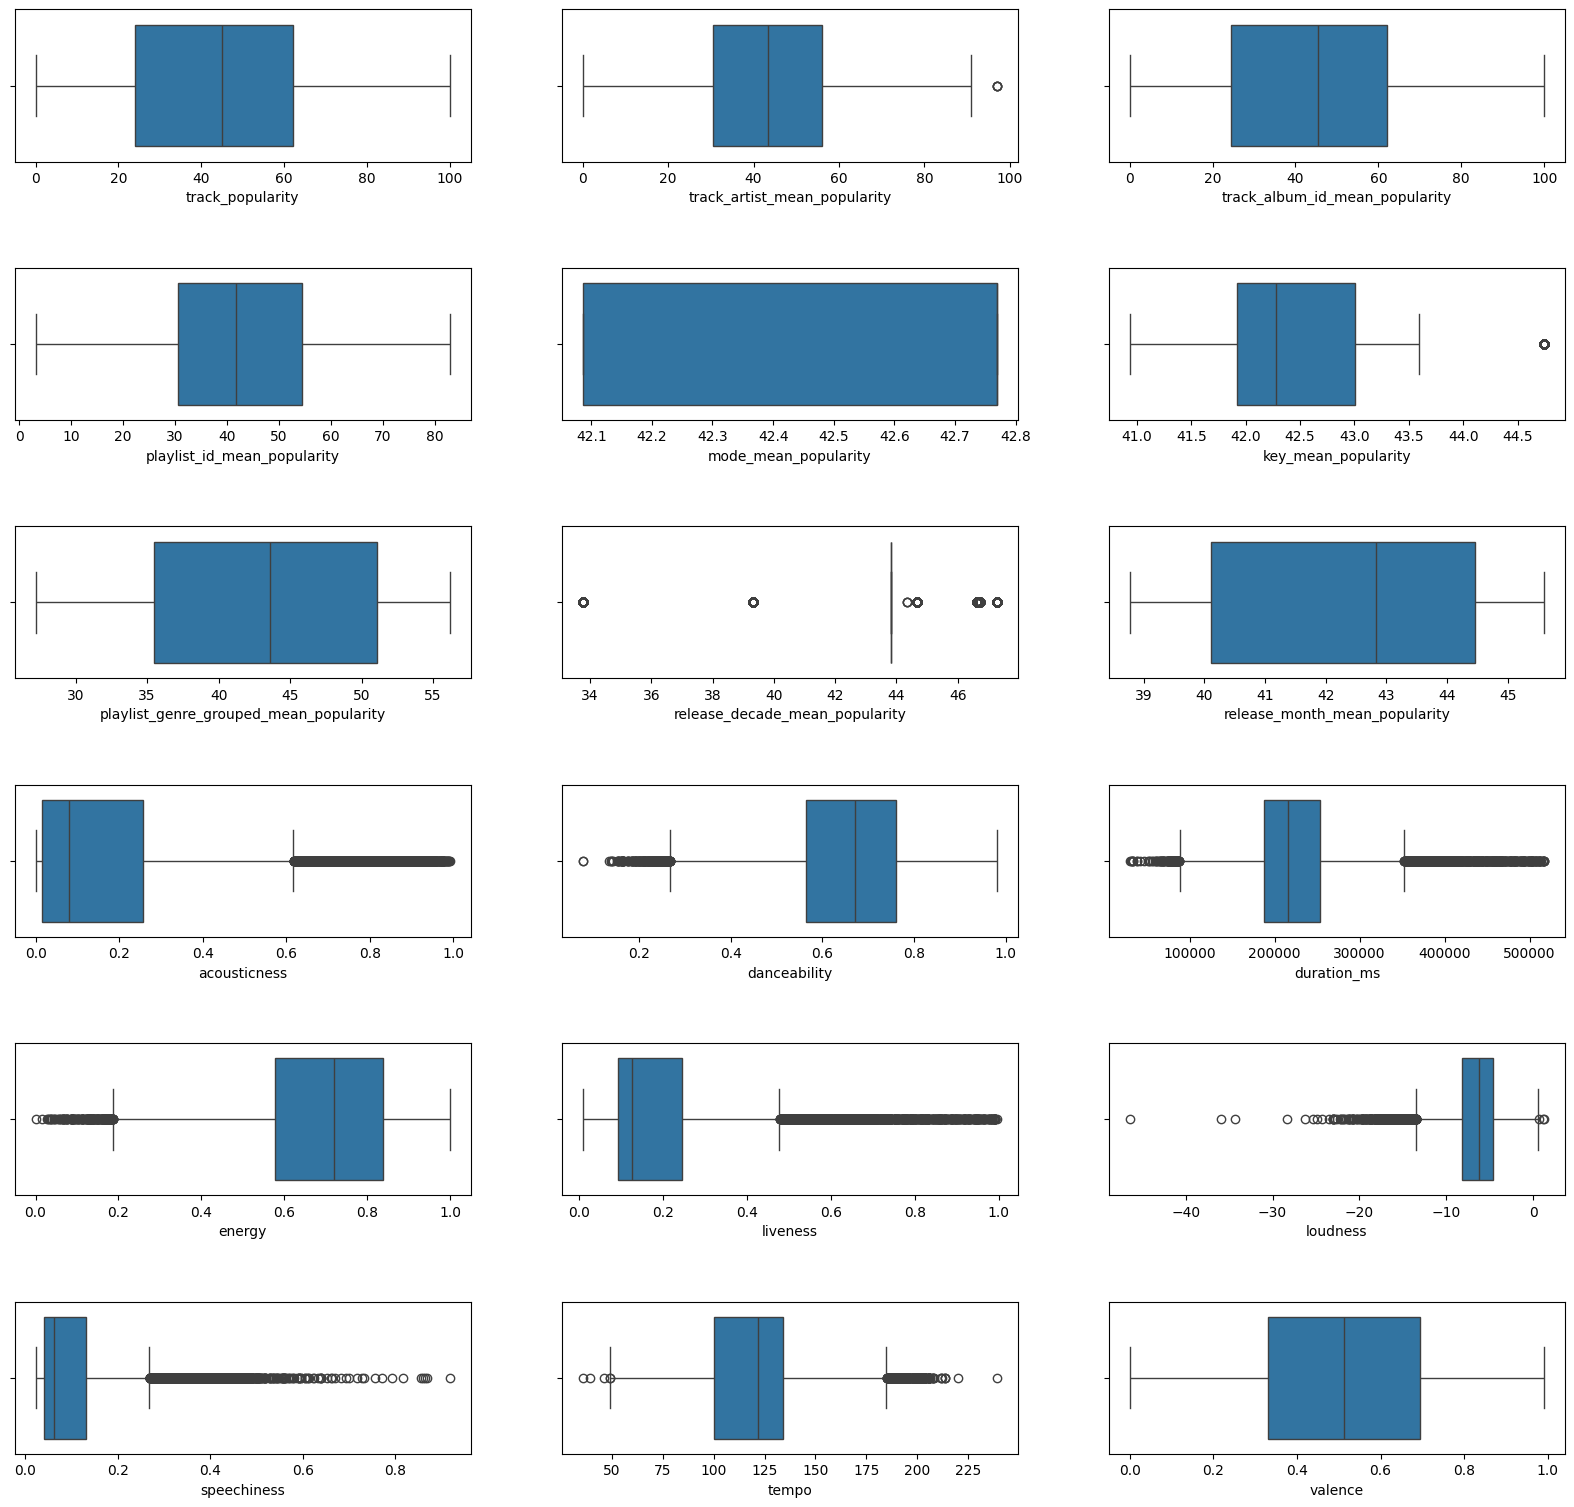

In [ ]:
## boxplots
cols_to_plot = [y_col] + large_cat_cols + small_cat_cols + cont_cols

plt.figure(figsize=(20,200))
for plot_counter, col in enumerate(cols_to_plot, start=1):
  ax = plt.subplot(60, 3, plot_counter)
  sb.boxplot(data=df, x=col, ax=ax)
  plt.subplots_adjust(hspace = 0.7)

plt.show()



# Correlations, Pairpolts




 Highest positive correlations
track_album_id_mean_popularity  track_popularity                0.990850
                                track_artist_mean_popularity    0.765162
track_popularity                track_artist_mean_popularity    0.758951
loudness                        energy                          0.675564
playlist_id_mean_popularity     track_popularity                0.644169
track_album_id_mean_popularity  playlist_id_mean_popularity     0.642034
track_artist_mean_popularity    playlist_id_mean_popularity     0.598194
valence                         danceability                    0.332432
danceability                    speechiness                     0.182066
liveness                        energy                          0.160719
dtype: float64

 Highest Negative correlations
acousticness                    energy                         -0.544705
loudness                        acousticness                   -0.368397
duration_ms                     playlist_id_m

<Axes: >

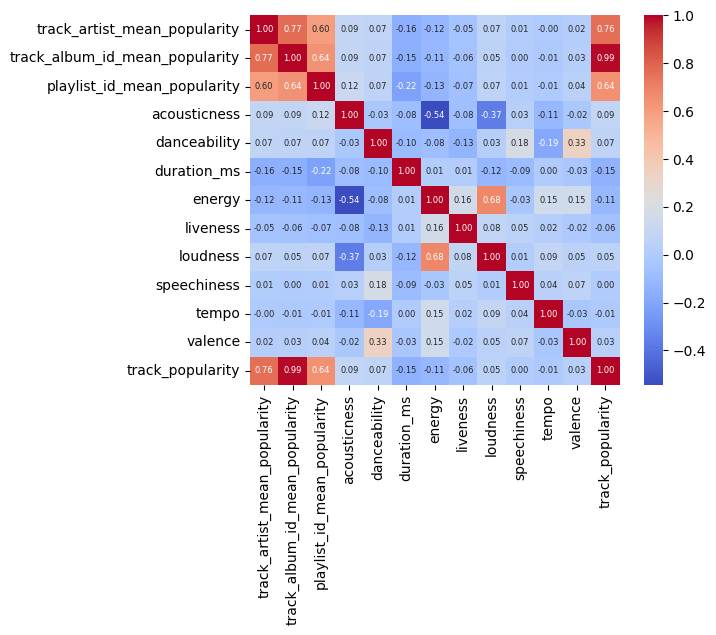

In [ ]:
# calculating highest and lowest correlations
corr = df[large_cat_cols + cont_cols + [y_col]].corr() #(method='spearman')

# Unstack into pairs
corr_pairs = corr.unstack()

# Drop self-correlations
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Sort by correlation value
sorted_corr = corr_pairs.sort_values(ascending=False)

print()
print(f"{BG_BRIGHT_RED} Highest positive correlations{RESET}")
print(sorted_corr.head(20)[::2])
print()
print(f"{BG_BRIGHT_BLUE} Highest Negative correlations{RESET}")
print(sorted_corr.tail(20)[-1::-2])

sb.heatmap(corr, cbar = True,  square=True, annot=True, annot_kws={'size': 6}, fmt=".2f", cmap= 'coolwarm')

In [ ]:
pair_plots = [large_cat_cols+[y_col], cont_cols+[y_col]]

for plot in pair_plots:
  pp = sb.pairplot(df, vars=plot, height=3, aspect=1.1)
  pp.fig.subplots_adjust(wspace=0.15, hspace=0.15)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Anova

In [ ]:
def show_anova(*samples, names=None, groups_title=None):

  if names is None: names = [f"Sample {i+1}" for i in range(len(samples))]
  if groups_title is None: groups_title = 'groups'

  # Run ANOVA
  f_stat, p_val = stats.f_oneway(*samples)

  if (p_val < 0.05): print(f"{BG_BRIGHT_RED}There is a significant difference between {groups_title}{RESET}")
  else: print(f"{BG_BRIGHT_GREEN}No significant difference between {groups_title}{RESET}")

  # Summary table
  summary = pd.DataFrame({
      "Group": names,
      "Mean": [pd.Series(s).mean() for s in samples],
      "Variance": [pd.Series(s).var() for s in samples],
      "N": [len(s) for s in samples]
    })

  print("\nSummary Table")
  print("-------------")
  print(summary)
  print()
  print("ANOVA Results")
  print("-------------")
  print(f"F-statistic: {f_stat:.4f}")
  print(f"p-value:     {p_val:.4e}\n")


  plt.figure(figsize=(8, 4))

  # Plot the density of each group
  for i in range(len(samples)):
    sb.histplot(samples[i], kde=True, label=names[i], color=f'C{i}', bins=20, stat="density", alpha=0.5)
    plt.axvline(np.mean(samples[i]), color=f'C{i}', linestyle='--', linewidth=1)

  plt.ylabel('Density', fontsize=12)
  plt.legend(fontsize=10)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.grid(False)

  plt.show()

  return



################################ ANOVA on popularity between groups with very large categories #################################

No significant difference between popularity of groups with very large categories

Summary Table
-------------
                            Group       Mean    Variance     N
0    track_artist_mean_popularity  42.801919  369.149621  1000
1  track_album_id_mean_popularity  41.317424  631.830323  1000
2     playlist_id_mean_popularity  42.715459  245.867350  1000
3                track_popularity  42.276000  600.456280  1000

ANOVA Results
-------------
F-statistic: nan
p-value:     nan



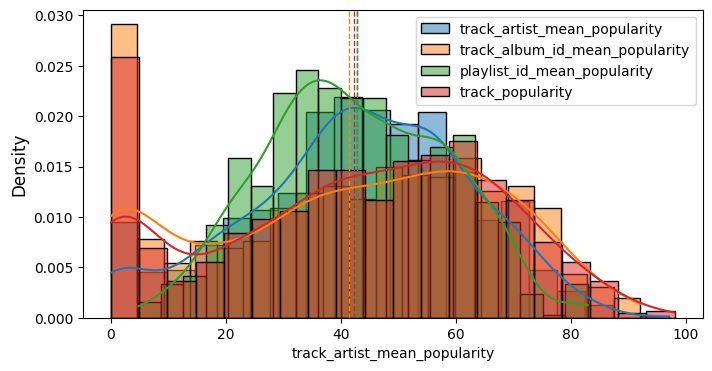

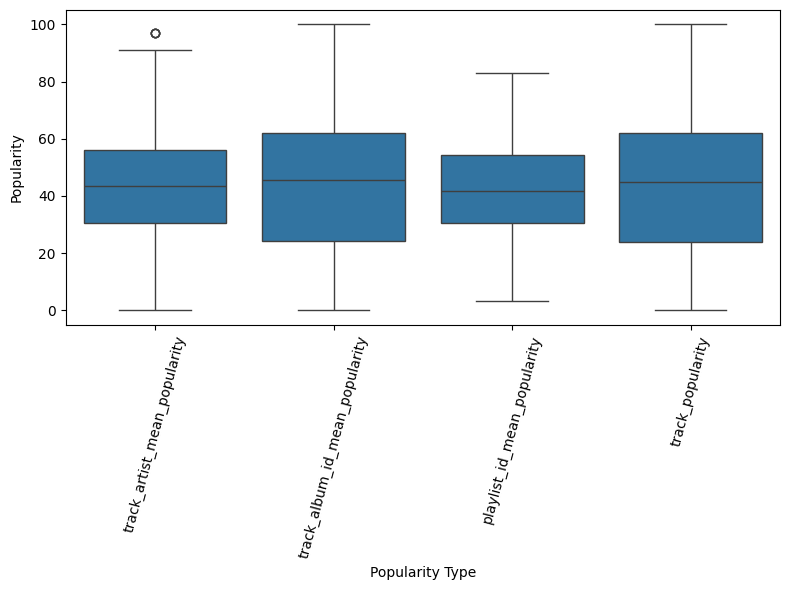

In [ ]:
print('\n\n################################ ANOVA on popularity between groups with very large categories #################################\n')

popularity_groups = large_cat_cols + [y_col]
sample_size = 1000

samples = [df[col].sample(sample_size) for col in popularity_groups]

show_anova(*samples,
           names=popularity_groups,
           groups_title='popularity of groups with very large categories')

# Melt into long format for seaborn
df_melt = df.melt(value_vars=popularity_groups, var_name='Popularity Type', value_name='Popularity')
plt.figure(figsize=(8,6))
sb.boxplot(x='Popularity Type', y='Popularity', data=df_melt)
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()





########################## ANOVA between popularity of categories in mode #############################

No significant difference between categories of mode

Summary Table
-------------
   Group    Mean    Variance     N
0  Major  43.115  626.428203  1000
1  Minor  42.631  615.184023  1000

ANOVA Results
-------------
F-statistic: 0.1887
p-value:     6.6407e-01



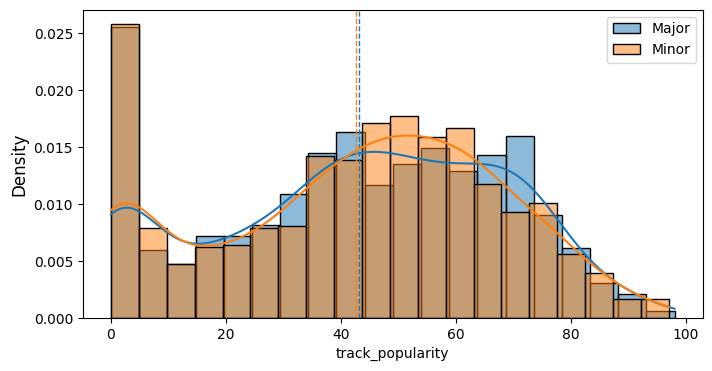

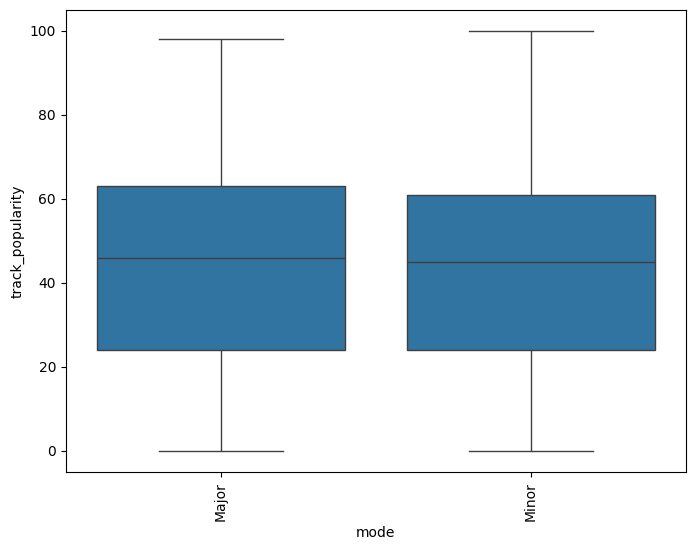




########################## ANOVA between popularity of categories in key #############################

No significant difference between categories of key

Summary Table
-------------
    Group    Mean    Variance     N
0   C♯/D♭  43.768  607.681858  1000
1       C  42.724  582.754579  1000
2       G  41.073  635.264936  1000
3       A  41.829  644.778538  1000
4       B  42.057  639.018770  1000
5       D  41.635  612.996772  1000
6       F  42.202  613.792989  1000
7   F♯/G♭  42.026  653.604929  1000
8   G♯/A♭  44.266  606.593838  1000
9   A♯/B♭  42.563  669.559591  1000
10      E  42.432  624.848224  1000

ANOVA Results
-------------
F-statistic: 1.3492
p-value:     1.9761e-01



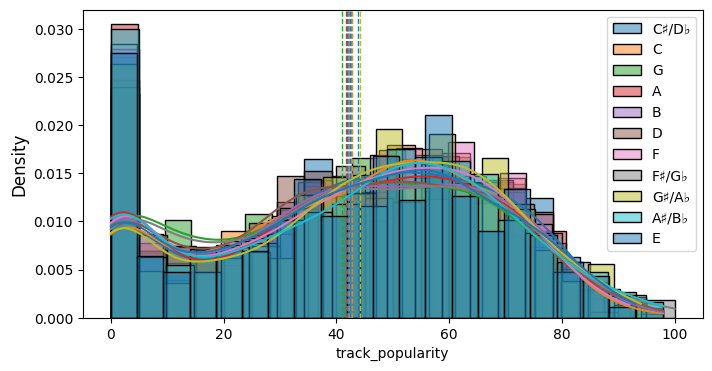

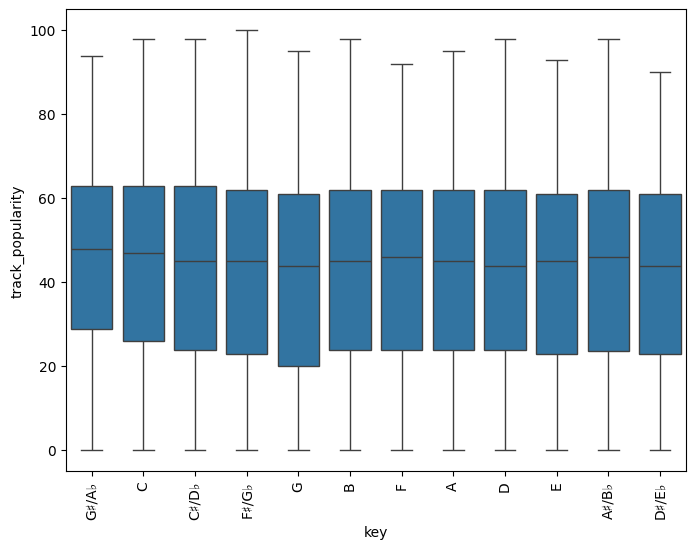




########################## ANOVA between popularity of categories in playlist_genre_grouped #############################

There is a significant difference between categories of playlist_genre_grouped

Summary Table
-------------
                         Group    Mean    Variance     N
0     Electro/Latin Pop Fusion  44.293  635.941092  1000
1  Hardcore Hip-Hop & Rock/EDM  36.269  537.111751  1000
2     Mainstream Pop & Hip-Hop  53.742  504.455892  1000
3           Latin & Urban Trap  52.216  527.767111  1000
4     Retro Swing & Prog House  27.628  471.685301  1000
5          Soul & Big Room EDM  32.691  493.669188  1000
6                 Classic Rock  38.813  634.506538  1000

ANOVA Results
-------------
F-statistic: 175.9156
p-value:     3.6199e-209



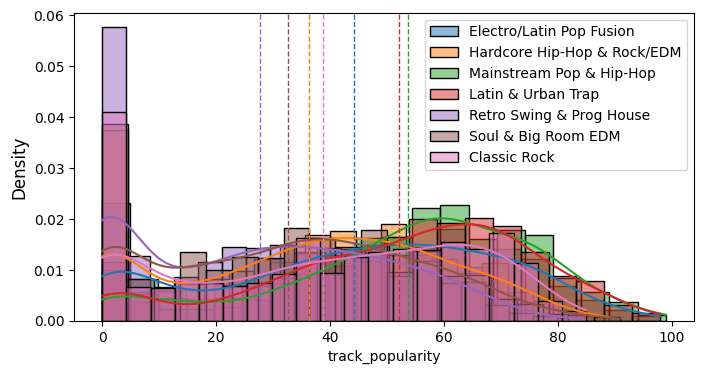

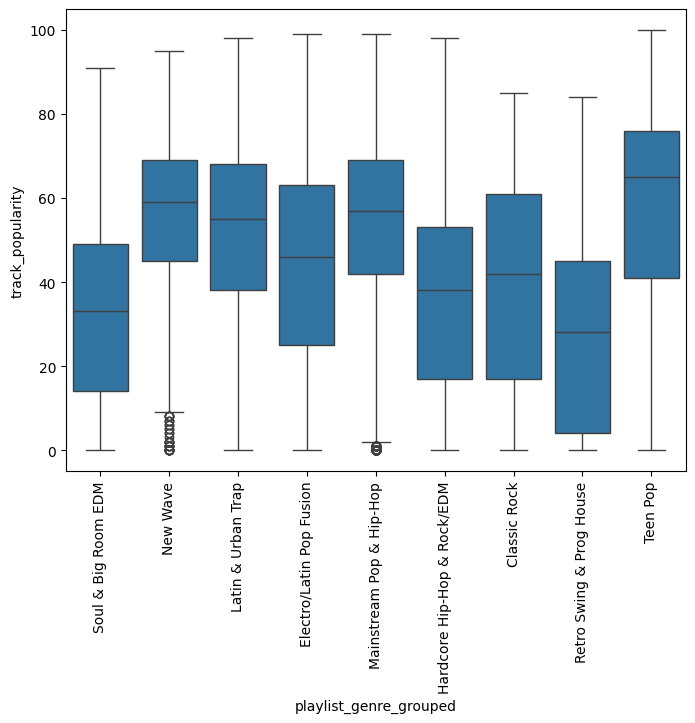




########################## ANOVA between popularity of categories in release_decade #############################

There is a significant difference between categories of release_decade

Summary Table
-------------
   Group    Mean    Variance     N
0   2010  44.537  587.906538  1000
1   2000  33.338  697.164921  1000
2   1990  39.698  544.357153  1000

ANOVA Results
-------------
F-statistic: 51.7329
p-value:     8.1626e-23



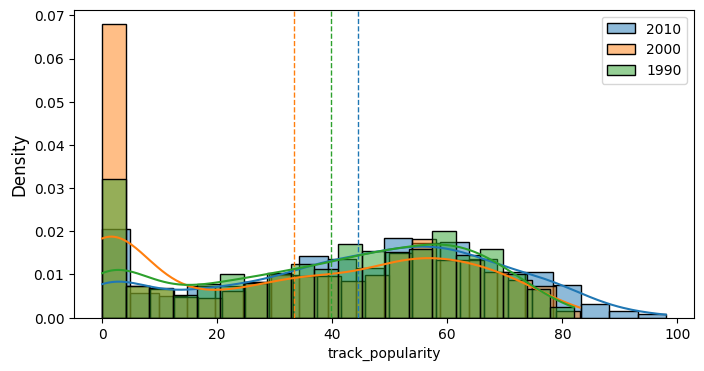

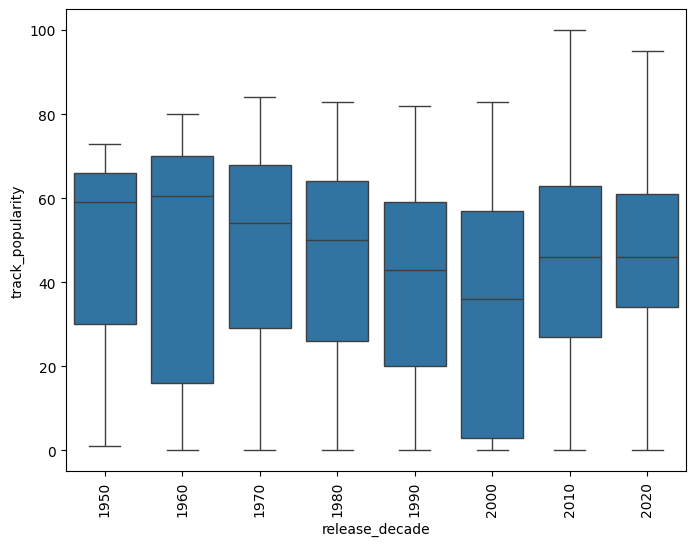




########################## ANOVA between popularity of categories in release_month #############################

There is a significant difference between categories of release_month

Summary Table
-------------
    Group    Mean    Variance     N
0       1  39.246  628.584068  1000
1      11  46.350  597.040541  1000
2      10  44.314  637.450855  1000
3       9  44.687  608.791823  1000
4      12  43.722  587.219936  1000
5       6  42.707  637.802954  1000
6       8  43.506  644.202166  1000
7       5  42.680  630.141742  1000
8       3  41.051  614.805204  1000
9       7  43.065  620.305080  1000
10      4  40.744  618.030494  1000
11      2  42.013  609.368199  1000

ANOVA Results
-------------
F-statistic: 5.9308
p-value:     1.0380e-09



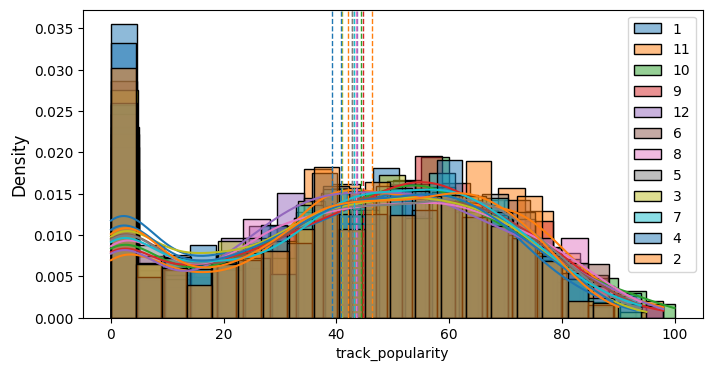

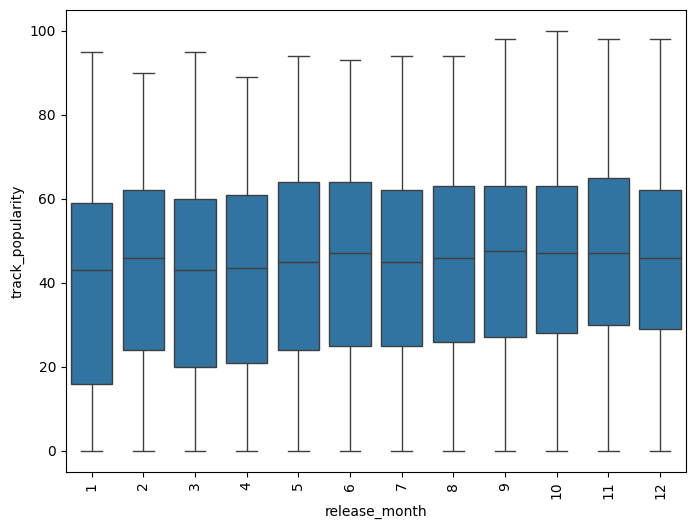




########################## ANOVA between popularity of categories in release_year #############################

There is a significant difference between categories of release_year

Summary Table
-------------
   Group    Mean    Variance     N
0   2019  51.669  408.491931  1000
1   2018  46.086  580.765369  1000
2   2017  41.414  640.721325  1000
3   2016  38.186  625.761165  1000
4   2015  35.199  694.728127  1000
5   2014  29.443  617.304055  1000

ANOVA Results
-------------
F-statistic: 105.0505
p-value:     1.3173e-106



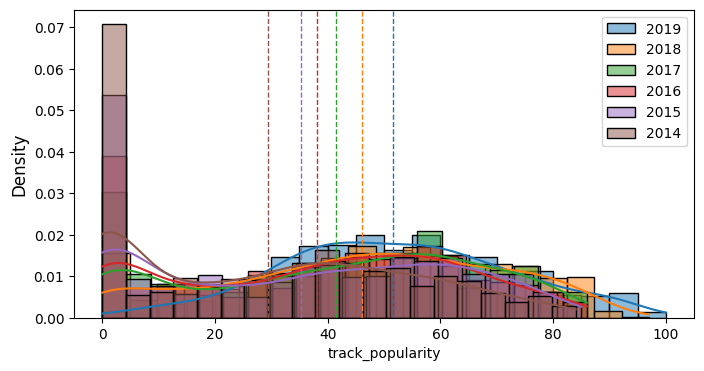

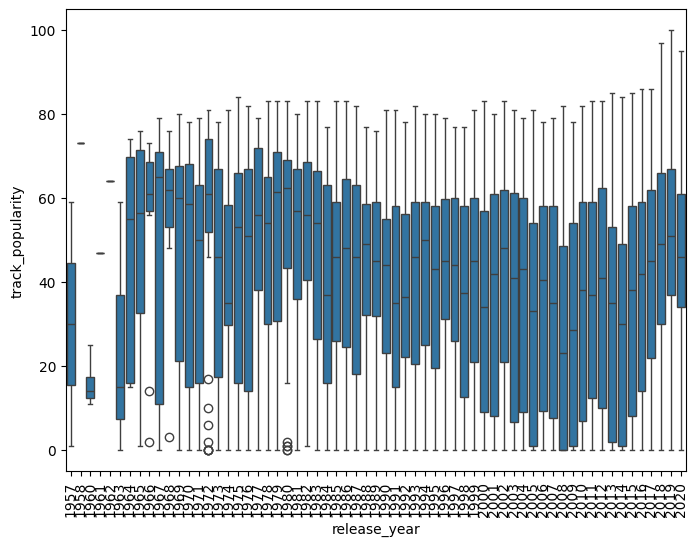

In [ ]:
for col in small_cat_symboles:

  print(f'\n\n\n########################## ANOVA between popularity of categories in {col} #############################\n')

  sample_size = 1000
  groups_names = list(df[col].value_counts().index)

  # Filter out groups with fewer than sample_size records
  valid_groups = [name for name in groups_names if len(df[df[col]==name]['track_popularity']) >= sample_size]

  # Create a list of samples for ANOVA from valid groups
  samples = [df[df[col]==name]['track_popularity'].sample(sample_size) for name in valid_groups]

  show_anova(*samples, names=valid_groups, groups_title=f"categories of {col}")

  plt.figure(figsize=(8,6))
  sb.boxplot(x=col, y='track_popularity', data=df)
  plt.xticks(rotation=90)
  plt.show()




####################### ANOVA between popularity of 10 bins of acousticness ##############################

There is a significant difference between acousticness bins

Summary Table
-------------
  Group    Mean    Variance     N
0  bin0  34.335  576.375150  1000
1  bin1  36.420  582.746346  1000
2  bin2  40.674  662.404128  1000
3  bin3  41.540  636.749149  1000
4  bin4  42.806  627.946310  1000
5  bin5  45.197  661.503695  1000
6  bin6  44.736  620.791095  1000
7  bin7  44.807  617.623374  1000
8  bin8  45.585  581.121897  1000
9  bin9  45.227  544.417889  1000

ANOVA Results
-------------
F-statistic: 25.6674
p-value:     3.4789e-44



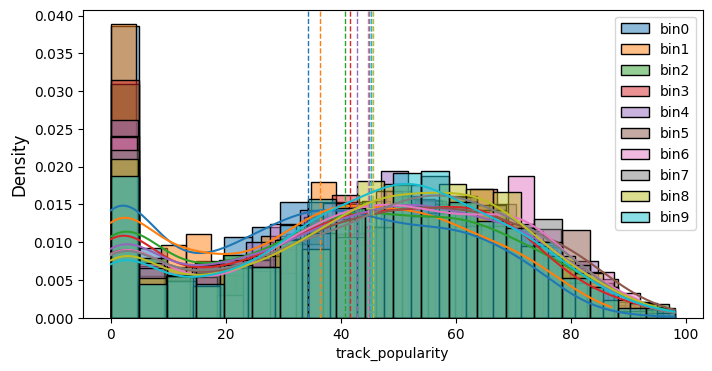

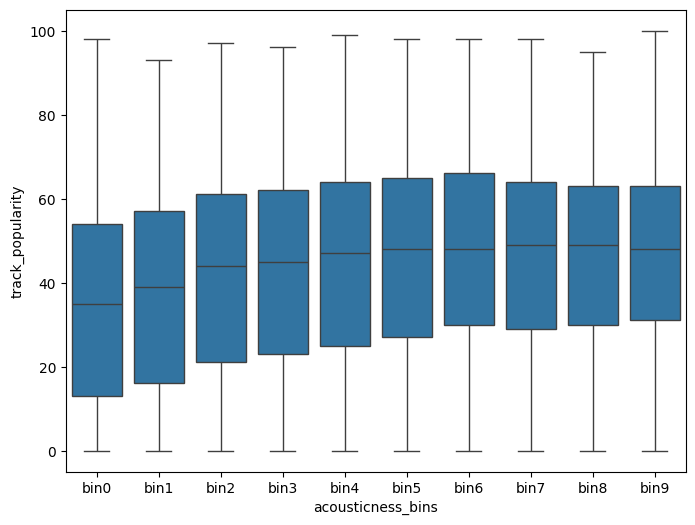



####################### ANOVA between popularity of 10 bins of danceability ##############################

There is a significant difference between danceability bins

Summary Table
-------------
  Group    Mean    Variance     N
0  bin0  40.144  605.941205  1000
1  bin1  42.072  616.361177  1000
2  bin2  40.105  628.140115  1000
3  bin3  40.136  591.226731  1000
4  bin4  40.935  617.916692  1000
5  bin5  41.409  602.532251  1000
6  bin6  41.806  590.148513  1000
7  bin7  44.376  629.115740  1000
8  bin8  43.840  659.157558  1000
9  bin9  45.810  623.397297  1000

ANOVA Results
-------------
F-statistic: 6.4071
p-value:     4.0210e-09



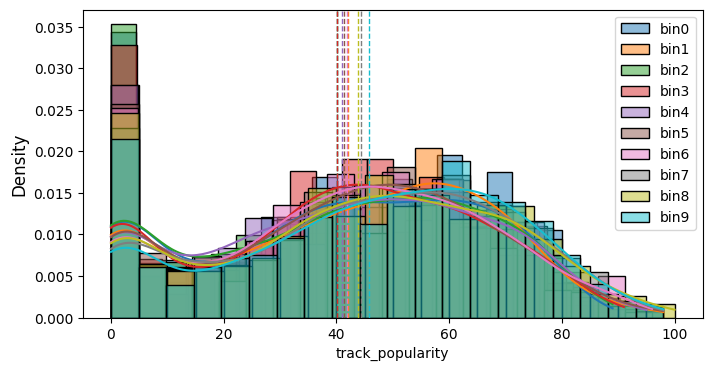

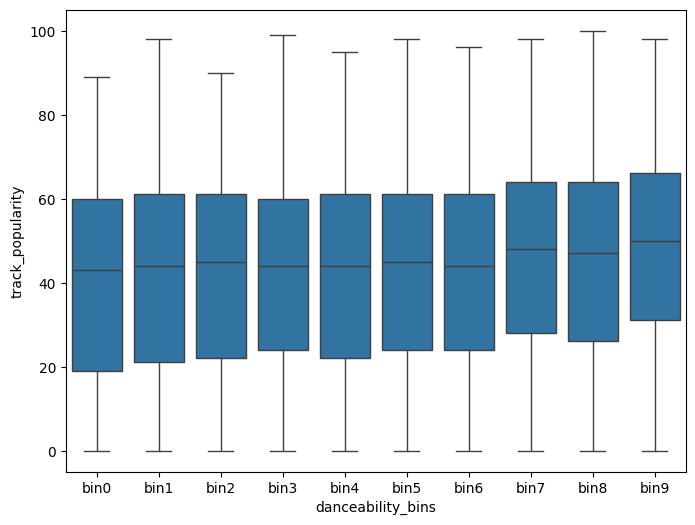



####################### ANOVA between popularity of 10 bins of duration_ms ##############################

There is a significant difference between duration_ms bins

Summary Table
-------------
  Group    Mean    Variance     N
0  bin0  46.207  496.036187  1000
1  bin1  44.135  537.258033  1000
2  bin2  44.700  578.988989  1000
3  bin3  44.930  649.006106  1000
4  bin4  44.661  629.077156  1000
5  bin5  44.678  633.579896  1000
6  bin6  42.398  647.441037  1000
7  bin7  40.863  611.563795  1000
8  bin8  38.434  671.122767  1000
9  bin9  32.510  645.261161  1000

ANOVA Results
-------------
F-statistic: 28.3047
p-value:     4.5020e-49



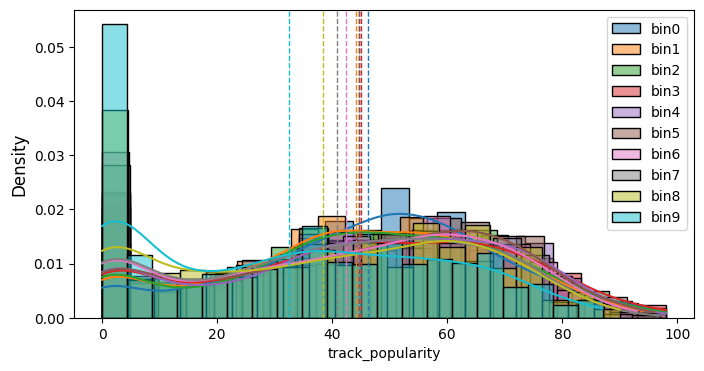

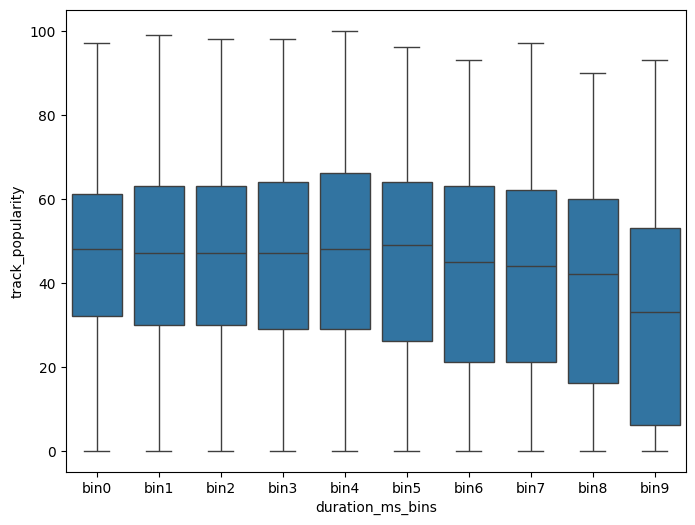



####################### ANOVA between popularity of 10 bins of energy ##############################

There is a significant difference between energy bins

Summary Table
-------------
  Group    Mean    Variance     N
0  bin0  46.044  547.697762  1000
1  bin1  45.422  653.125041  1000
2  bin2  44.882  615.873950  1000
3  bin3  44.509  623.107026  1000
4  bin4  45.155  619.370345  1000
5  bin5  43.577  628.736808  1000
6  bin6  43.383  625.421733  1000
7  bin7  38.986  599.721526  1000
8  bin8  39.332  588.722498  1000
9  bin9  34.315  575.923699  1000

ANOVA Results
-------------
F-statistic: 23.6088
p-value:     2.2591e-40



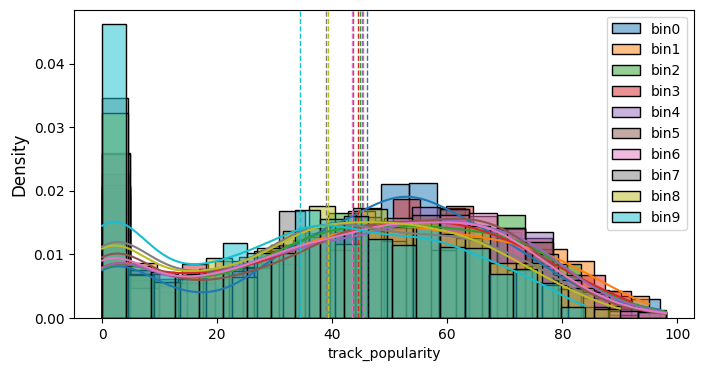

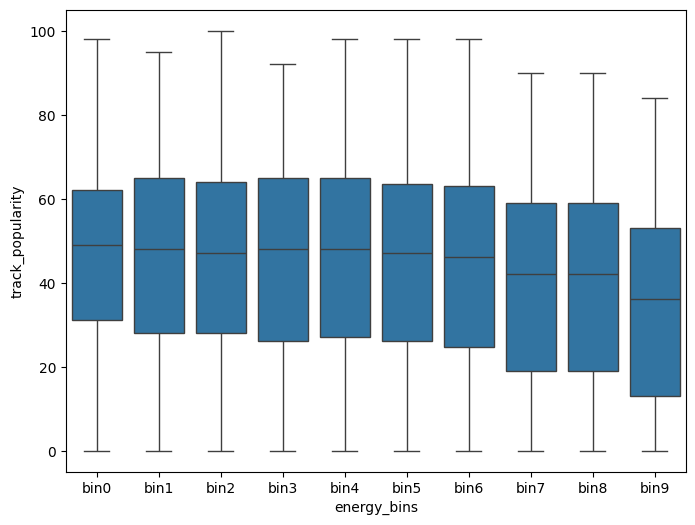



####################### ANOVA between popularity of 10 bins of liveness ##############################

There is a significant difference between liveness bins

Summary Table
-------------
  Group    Mean    Variance     N
0  bin0  39.893  639.903454  1000
1  bin1  43.573  599.546217  1000
2  bin2  44.300  657.609610  1000
3  bin3  46.205  620.375350  1000
4  bin4  44.602  551.441037  1000
5  bin5  43.296  639.409794  1000
6  bin6  42.895  594.810786  1000
7  bin7  42.026  639.841165  1000
8  bin8  40.539  603.379859  1000
9  bin9  38.725  605.625000  1000

ANOVA Results
-------------
F-statistic: 8.7294
p-value:     3.5387e-13



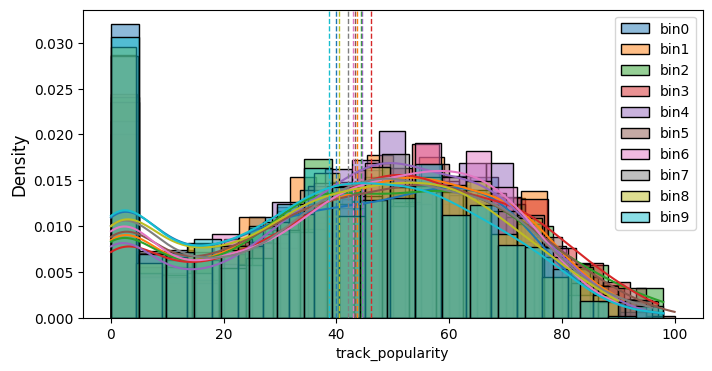

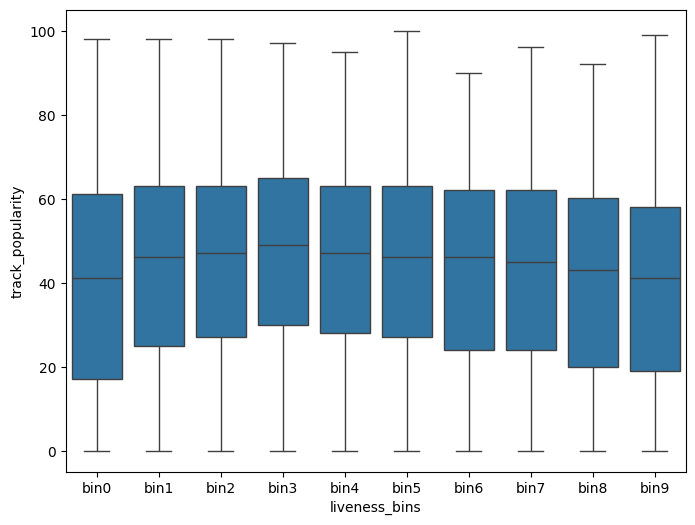



####################### ANOVA between popularity of 10 bins of loudness ##############################

There is a significant difference between loudness bins

Summary Table
-------------
  Group    Mean    Variance     N
0  bin0  38.705  553.385360  1000
1  bin1  38.783  589.623535  1000
2  bin2  42.165  597.136912  1000
3  bin3  42.298  617.310507  1000
4  bin4  44.836  592.513618  1000
5  bin5  44.126  675.451576  1000
6  bin6  43.077  627.614686  1000
7  bin7  43.620  605.174775  1000
8  bin8  44.594  650.715880  1000
9  bin9  40.604  716.333518  1000

ANOVA Results
-------------
F-statistic: 8.1315
p-value:     4.0229e-12



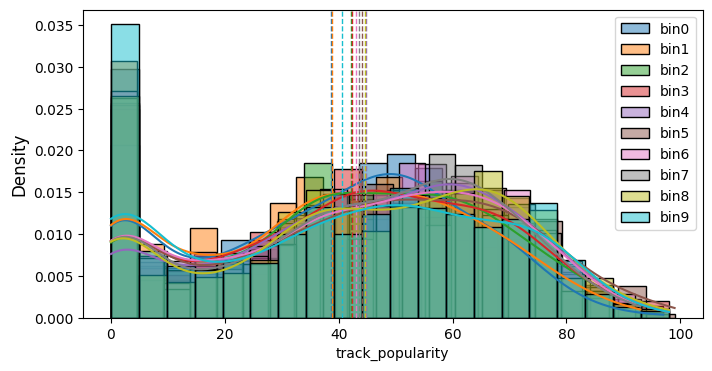

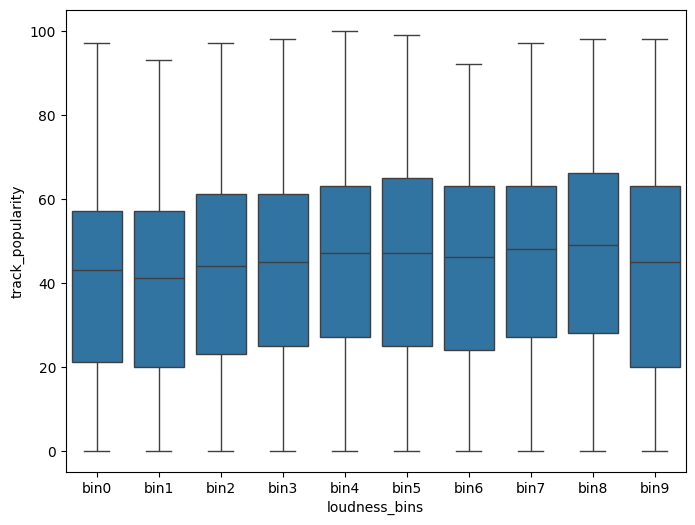



####################### ANOVA between popularity of 10 bins of speechiness ##############################

No significant difference between speechiness bins

Summary Table
-------------
  Group    Mean    Variance     N
0  bin0  43.209  609.402722  1000
1  bin1  42.449  589.516916  1000
2  bin2  42.018  609.192869  1000
3  bin3  42.460  608.755155  1000
4  bin4  42.130  630.235335  1000
5  bin5  42.299  674.373973  1000
6  bin6  43.154  648.324609  1000
7  bin7  43.384  590.090635  1000
8  bin8  41.203  618.286077  1000
9  bin9  43.081  648.164604  1000

ANOVA Results
-------------
F-statistic: 0.7371
p-value:     6.7517e-01



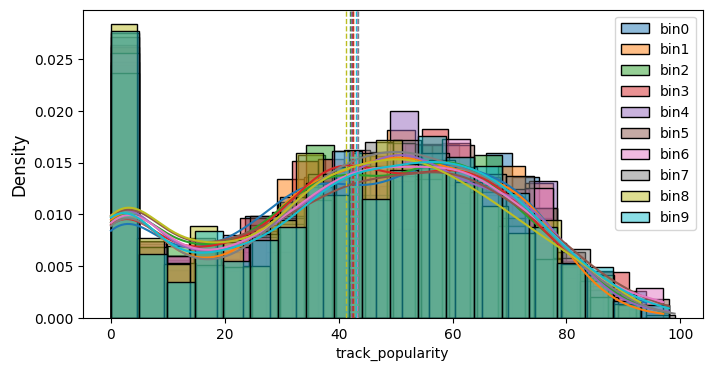

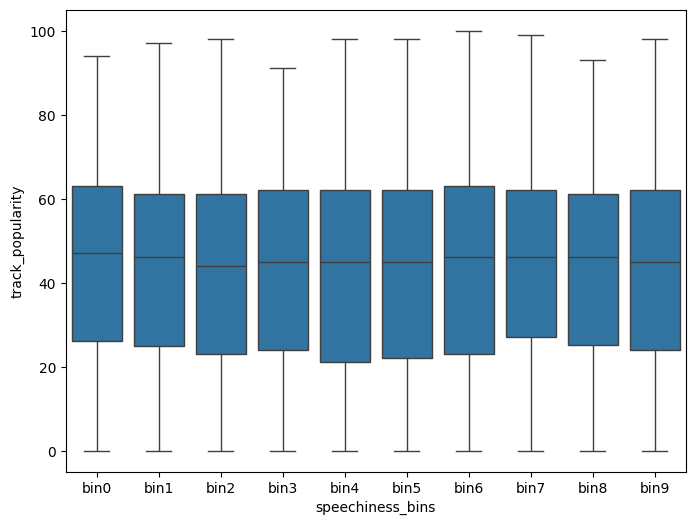



####################### ANOVA between popularity of 10 bins of tempo ##############################

There is a significant difference between tempo bins

Summary Table
-------------
  Group    Mean    Variance     N
0  bin0  41.331  584.574013  1000
1  bin1  44.524  676.331756  1000
2  bin2  45.230  636.801902  1000
3  bin3  44.527  611.490762  1000
4  bin4  43.610  592.670571  1000
5  bin5  41.780  544.938539  1000
6  bin6  33.334  618.619063  1000
7  bin7  42.904  606.759544  1000
8  bin8  42.776  562.192016  1000
9  bin9  44.356  644.389654  1000

ANOVA Results
-------------
F-statistic: 19.4549
p-value:     1.0769e-32



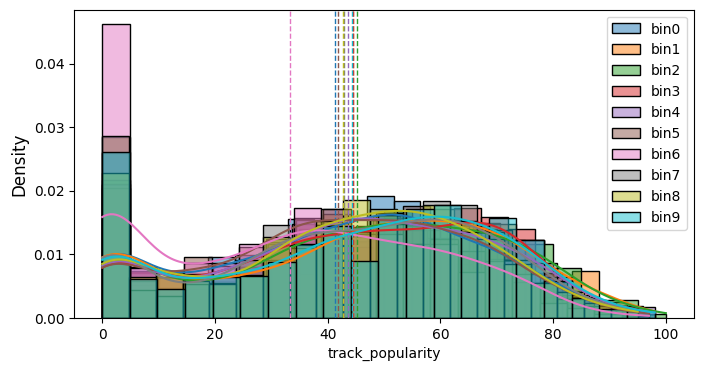

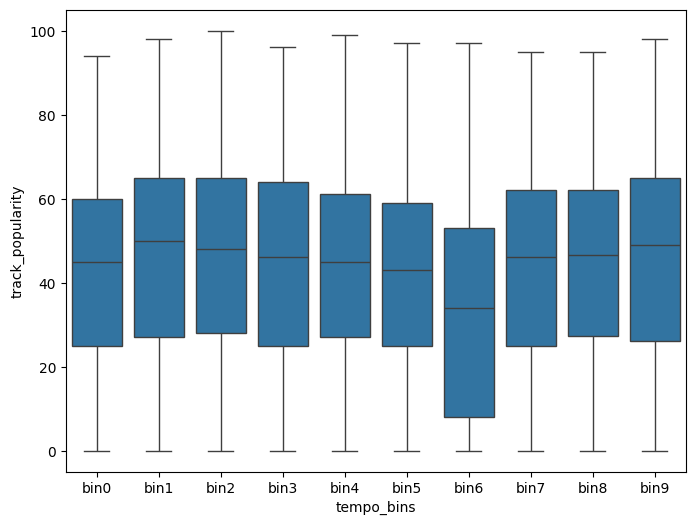



####################### ANOVA between popularity of 10 bins of valence ##############################

There is a significant difference between valence bins

Summary Table
-------------
  Group    Mean    Variance     N
0  bin0  39.728  614.802819  1000
1  bin1  39.811  572.073352  1000
2  bin2  42.104  601.558743  1000
3  bin3  43.887  637.087318  1000
4  bin4  44.746  584.501986  1000
5  bin5  44.266  655.873117  1000
6  bin6  43.261  613.338217  1000
7  bin7  43.295  632.604580  1000
8  bin8  41.348  639.566462  1000
9  bin9  42.576  664.384609  1000

ANOVA Results
-------------
F-statistic: 4.9520
p-value:     1.1490e-06



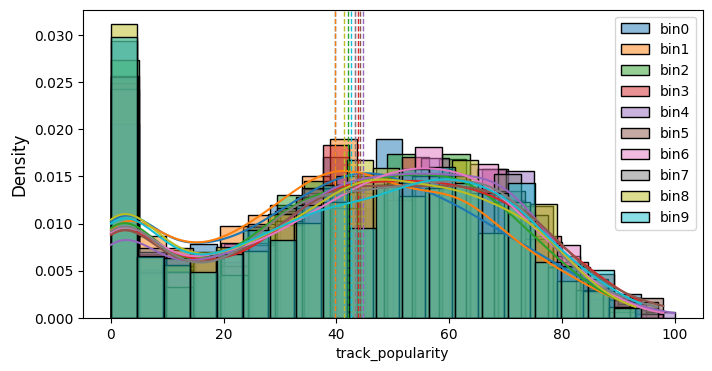

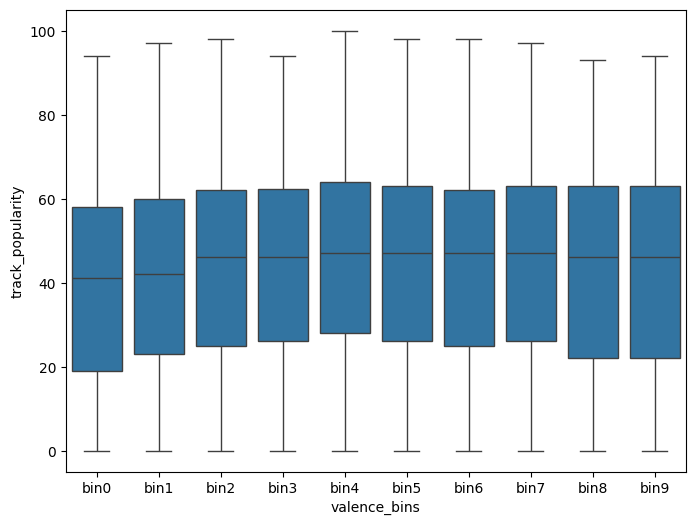

In [ ]:
sample_size = 1000
n_bins = 10
bin_labels = [f"bin{i}" for i in range(n_bins)]

for col in cont_cols:
  print(f'\n\n####################### ANOVA between popularity of {n_bins} bins of {col} ##############################\n')

  df[f"{col}_bins"] = pd.qcut(df[col], q=n_bins, labels=bin_labels)

  samples = [df[df[f"{col}_bins"]==label]['track_popularity'].sample(sample_size) for label in bin_labels]

  show_anova(*samples, names=bin_labels, groups_title=f"{col} bins")

  plt.figure(figsize=(8,6))
  sb.boxplot(x=f"{col}_bins", y='track_popularity', data=df)
  plt.show()

  df.drop(columns=[f"{col}_bins"], inplace=True)